## Project #4:

* Student name: Milena Afeworki
* Student pace: full time
* Scheduled project review date/time: 08/05/2021 @ 10:15 PT
* Instructor name: Abhineet Kulkarni 
* Blog post URL:

# Time series Prediction on California Home sales

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima import auto_arima
from matplotlib.pylab import rcParams
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.shape

(14723, 272)

# Step 2: Data Preprocessing

Let's replace the column 'RegionName' by 'ZipCode' and then select only the data for California and drop the rest.

In [4]:
#Rename RegionName
df.rename({'RegionName': 'ZipCode'}, axis='columns', inplace=True)

In [5]:
#Delete all but CA zipcodes
df_ca = df.loc[df['State']== 'CA'].reset_index()
df_ca.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)
print('Total Zipcodes in DataFrame:', len(df_ca))

Total Zipcodes in DataFrame: 1224


In [6]:
#Check for zeros
df_ca.describe()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,1224.000000,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,...,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03
mean,93308.559641,2.002210e+05,2.001248e+05,2.000359e+05,1.999656e+05,1.999588e+05,2.000376e+05,2.002770e+05,2.006430e+05,2.013097e+05,...,6.923672e+05,6.978696e+05,7.040457e+05,7.105151e+05,7.167609e+05,7.232635e+05,7.294964e+05,7.355260e+05,7.421463e+05,7.463291e+05
std,1800.792540,1.260446e+05,1.265337e+05,1.270587e+05,1.276189e+05,1.282251e+05,1.289055e+05,1.297123e+05,1.306263e+05,1.318064e+05,...,6.210660e+05,6.261215e+05,6.324982e+05,6.395856e+05,6.464928e+05,6.534314e+05,6.601518e+05,6.662484e+05,6.724521e+05,6.760173e+05
min,90001.000000,4.440000e+04,4.390000e+04,4.350000e+04,4.290000e+04,4.240000e+04,4.180000e+04,4.120000e+04,4.070000e+04,4.040000e+04,...,5.950000e+04,6.240000e+04,6.580000e+04,6.790000e+04,6.960000e+04,7.110000e+04,7.190000e+04,7.260000e+04,7.380000e+04,7.450000e+04
25%,92013.250000,1.294750e+05,1.286750e+05,1.283750e+05,1.280000e+05,1.277000e+05,1.275750e+05,1.272000e+05,1.268750e+05,1.266750e+05,...,3.281750e+05,3.314500e+05,3.344250e+05,3.368250e+05,3.384500e+05,3.391500e+05,3.414500e+05,3.446500e+05,3.467250e+05,3.483750e+05
50%,93302.500000,1.635000e+05,1.628500e+05,1.625000e+05,1.622000e+05,1.623500e+05,1.622000e+05,1.625000e+05,1.624000e+05,1.626500e+05,...,5.305000e+05,5.350000e+05,5.378500e+05,5.424500e+05,5.463000e+05,5.503000e+05,5.529500e+05,5.572500e+05,5.625000e+05,5.647000e+05
75%,95035.500000,2.322500e+05,2.322250e+05,2.325000e+05,2.326000e+05,2.330250e+05,2.336250e+05,2.339750e+05,2.350500e+05,2.365000e+05,...,8.178500e+05,8.262250e+05,8.339500e+05,8.436250e+05,8.494750e+05,8.553500e+05,8.613000e+05,8.684750e+05,8.784250e+05,8.845500e+05
max,96161.000000,1.179200e+06,1.184300e+06,1.189700e+06,1.195400e+06,1.201200e+06,1.207300e+06,1.214100e+06,1.221200e+06,1.230900e+06,...,6.138300e+06,6.197800e+06,6.250200e+06,6.315400e+06,6.429100e+06,6.581800e+06,6.705000e+06,6.764600e+06,6.788400e+06,6.796500e+06


# Step 4: Reshape from Wide to Long Format

Our next step would be to change the format of the data frame from wide format to long format and index by the'Date' column 

In [7]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [8]:
melted_df = melt_data(df_ca)

We will also want to make sure we change zip code into a string so it is not confused for an integer.

In [9]:
#Change Zipcode dtype to 'str'
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

In [10]:
melted_df.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=318744, freq=None)

In [11]:
melted_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,222400.0


In [12]:
melted_df.tail()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
2018-04-01,93517,Bridgeport,CA,NaN,Mono,272500.0
2018-04-01,95728,Truckee,CA,Truckee,Nevada,496300.0
2018-04-01,95497,Annapolis,CA,Santa Rosa,Sonoma,848700.0
2018-04-01,92322,Crestline,CA,Riverside,San Bernardino,200100.0
2018-04-01,92341,Green Valley Lake,CA,Riverside,San Bernardino,183600.0


In [13]:
melted_df.shape

(318744, 6)

# Step 3: EDA and Visualization


On this step we will be creating visualizations to get a better idea of what we are working with and also to understand the trends of the values in our data.

In [14]:
#check for nulls 
melted_df.isna().sum()

ZipCode           0
City              0
State             0
Metro         10602
CountyName        0
value             0
dtype: int64

In [15]:
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

In [16]:
county = melted_df.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

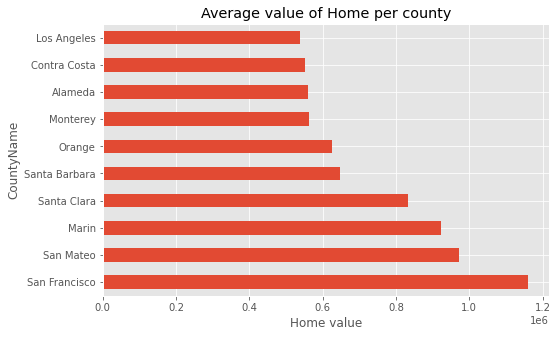

In [17]:
fig =plt.figure(figsize=(8,5))
county.plot.barh()
plt.title('Average value of Home per county')
plt.xlabel('Home value')
plt.show()

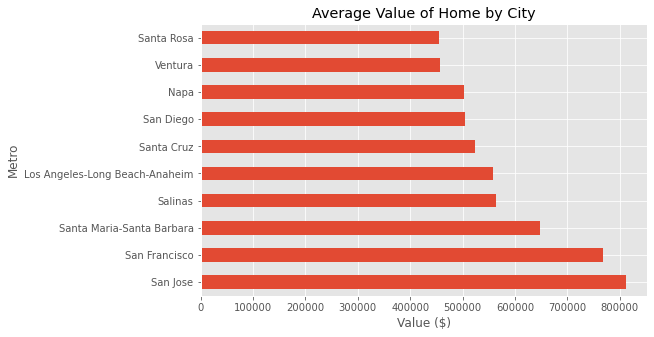

In [18]:
fig = plt.figure(figsize=(8,5))
metro.plot.barh()
plt.title('Average Value of Home by City')
plt.xlabel('Value ($)')
plt.show()


Here we get a good idea of the average home value per County name.

In [19]:
print('Average CA home value' ,round(melted_df['value'].mean()))

Average CA home value 457429


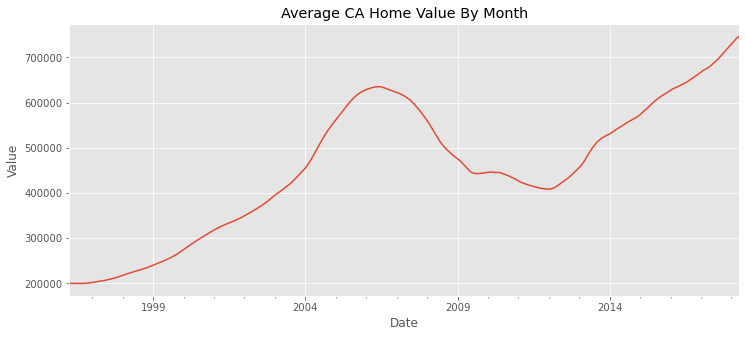

Date
1996-04-01    200220.959596
1996-05-01    200124.831650
1996-06-01    200035.942761
1996-07-01    199965.572391
1996-08-01    199958.754209
Freq: MS, Name: value, dtype: float64


In [20]:
#data resampled by month
monthly_data = melted_df['value'].resample('MS').mean()
monthly_data = monthly_data.fillna(monthly_data.bfill())
monthly_data.plot(figsize=(12,5))
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()
print(monthly_data.head())

<AxesSubplot:xlabel='Date'>

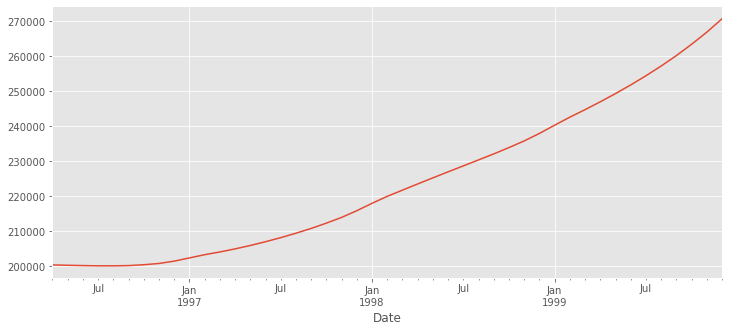

In [21]:
monthly_data['1996':'1999'].plot(figsize=(12,5))

<AxesSubplot:xlabel='Date'>

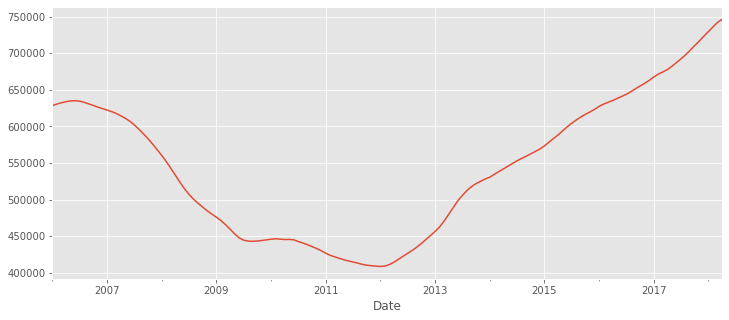

In [22]:
monthly_data['2006':].plot(figsize=(12,5))

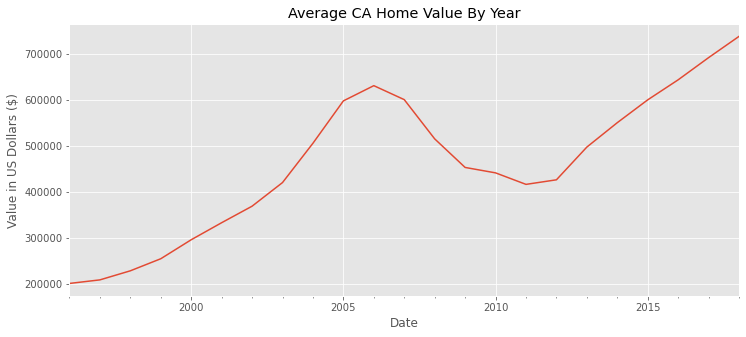

Date
1996-12-31    200285.933408
1997-12-31    208054.924242
1998-12-31    227790.333895
1999-12-31    254072.804433
2000-12-31    295432.870370
Freq: A-DEC, Name: value, dtype: float64


In [23]:
yearly_data = melted_df['value'].resample('A').mean()
yearly_data.plot.line(figsize=(12,5))
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()
print(yearly_data.head())

<AxesSubplot:>

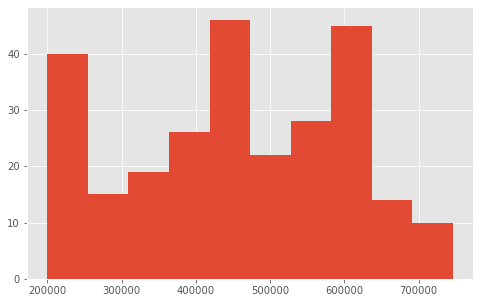

In [24]:
fig = plt.figure( figsize=(8,5))
monthly_data.hist()

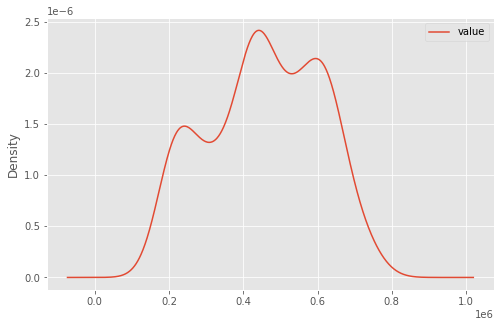

In [25]:
fig = plt.figure( figsize=(8,5))
monthly_data.plot(kind='kde')
plt.legend()

The monthly and yearly home values seem ot be similar. There doesn't seem to be any seasonality but we do see a generaly upward trend with a dip downward between the years 2007-2012.
Next, we will cut down on variation to ensure we get the true most valuable zip codes.

In [26]:
#taking into account the last 5years
df_ca.iloc[:,-60:].head()

,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,3024300.0,3084000.0,3128400.0,3149900.0,3168700.0,3181800.0,3177400.0,3171800.0,3181200.0,3197700.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,394600.0,401100.0,406500.0,411200.0,414400.0,415900.0,416600.0,417300.0,419000.0,421900.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,206100.0,210000.0,215500.0,222300.0,228100.0,233100.0,239400.0,246200.0,251800.0,255800.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,1185600.0,1200800.0,1214100.0,1228900.0,1242500.0,1253600.0,1260200.0,1263100.0,1265900.0,1273000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,669900.0,688000.0,698800.0,705000.0,709500.0,713500.0,713600.0,713000.0,715500.0,719700.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [27]:
df_ca['yr_avg']=df_ca.iloc[:,-60:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 2 decile above the median and 2 deciles below.
print(df_ca['yr_avg'].describe(),'\n')

#Calculate the 70% cutoff value (2 decile above).
q_70 = df_ca['yr_avg'].quantile(q=0.70)
print(f'Average Value 70% cutoff value: {round(q_70,2)}')

#Calculate the 30% cutoff value (2 deciles below).
q_30 = df_ca['yr_avg'].quantile(q=0.30)
print(f'Average Value 30% cutoff value: {round(q_30,2)}')

#Get data frame with selected zipcodes.
df_avg = df_ca[(df_ca['yr_avg']<q_70) & (df_ca['yr_avg']>q_30)]
print(f'Amount of zipcodes: {len(df_avg)}')

count    1.224000e+03
mean     6.146968e+05
std      5.553401e+05
min      5.477833e+04
25%      2.826767e+05
50%      4.664775e+05
75%      7.432292e+05
max      5.319428e+06
Name: yr_avg, dtype: float64 

Average Value 70% cutoff value: 654150.17
Average Value 30% cutoff value: 313131.83
Amount of zipcodes: 490


In [28]:
df_avg.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,585700,590900,594700,598500,601300,602800,606100,612400,616200,497491.666667
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,398400,401600,405400,408600,410900,413700,417900,424300,430100,324933.333333
7,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,119500.0,119500.0,119400.0,119300.0,119200.0,...,386900,390600,394300,398600,404200,409700,414300,418500,421100,321008.333333
8,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,128300.0,128100.0,127800.0,127500.0,127100.0,...,430600,434800,439300,443500,447700,451700,455000,457600,459100,374406.666667
9,95630,Folsom,CA,Sacramento,Sacramento,190000.0,189300.0,188500.0,187800.0,187300.0,...,529700,529500,531000,533300,537200,542400,544600,544100,542900,477610.000000


In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments. Ideally, if the coefficient of variation formula should result in a lower ratio of the standard deviation to mean return, then the better the risk-return trade-off. Therefore, in these next steps we are going to filter the data some more by calculating the CV value and only selecting values with in the company's risk factor (assume 60 percentile).

In [29]:
#Calculate historical return on investment
df_avg['ROI'] = (df_avg['yr_avg']/df_avg['1996-04'])-1

#Calculate standard deviation of monthly values
df_avg['std'] = df_avg.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_avg['mean'] = df_avg.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_avg['CV'] = df_avg['std']/df_avg['mean']

#Show calculated values
df_avg[['ZipCode','std','mean','ROI','CV','CountyName']].head()

,ZipCode,std,mean,ROI,CV,CountyName
1,90250,138601.533036,365464.150943,2.262240,0.379248,Los Angeles
2,94565,104006.852657,263874.339623,1.334291,0.394153,Contra Costa
7,90044,97293.744047,243829.811321,1.686262,0.399023,Los Angeles
8,90805,108971.123756,281955.471698,1.918213,0.386483,Los Angeles
9,95630,106331.603220,373722.264151,1.513737,0.284520,Sacramento


In [30]:
#find out the top 10 couties with highest ROI
grp_county = df_avg.groupby('CountyName', group_keys=False).sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

# sorted(round(grouped_county,2), reverse=True)[:10]

CountyName
Los Angeles       313.935844
San Diego         113.669953
Orange             70.569764
Riverside          41.097313
Ventura            32.937638
Sacramento         32.498056
San Bernardino     31.662873
Alameda            29.279048
Placer             27.415028
Sonoma             26.812512
Name: ROI, dtype: float64

In [31]:
#top 10 counties with highest ROI before considering risk factor CV
grp_county.sort_values(ascending=False)[:10].keys() 

Index(['Los Angeles', 'San Diego', 'Orange', 'Riverside', 'Ventura',
       'Sacramento', 'San Bernardino', 'Alameda', 'Placer', 'Sonoma'],
      dtype='object', name='CountyName')

In [32]:
#Descriptive statistics of coefficients of variance.
print(df_avg.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_avg.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 10 counties with highest ROIs within the firms risk profile.
df_top10 = df_avg[df_avg['CV']<upper_cv].sort_values('ROI', axis=0, ascending=False)

#find out the top 10 couties with highest ROI
grp_county = df_top10.groupby('CountyName').sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

count    490.000000
mean       0.342695
std        0.045802
min        0.062004
25%        0.316948
50%        0.343743
75%        0.367369
max        0.496292
Name: CV, dtype: float64

CV upper limit: 0.352771200684699


CountyName
San Diego          81.000270
Los Angeles        69.132190
Orange             29.551015
Riverside          28.391854
Placer             27.415028
Sonoma             26.812512
San Luis Obispo    24.860144
Sacramento         24.044008
Ventura            22.830799
Alameda            14.629467
Name: ROI, dtype: float64

Now for each county lets look into the zipcode with the highest ROI value and move onto the time series analysis


In [33]:
top10_county = list(grp_county.sort_values(ascending=False)[:10].index)
top10_county

['San Diego',
 'Los Angeles',
 'Orange',
 'Riverside',
 'Placer',
 'Sonoma',
 'San Luis Obispo',
 'Sacramento',
 'Ventura',
 'Alameda']

In [34]:
df_top10.shape

(294, 275)

In [35]:
df_top10 = df_top10.loc[df_top10['CountyName'].isin(top10_county)]
df_top10.shape

(204, 275)

In [36]:
df_top10['CountyName'].value_counts()

San Diego          44
Los Angeles        40
Riverside          21
Placer             18
Sacramento         17
Sonoma             16
Orange             14
San Luis Obispo    13
Ventura            13
Alameda             8
Name: CountyName, dtype: int64

In [37]:
df_top10.groupby('CountyName').max()['ROI']

CountyName
Alameda            2.231758
Los Angeles        2.216251
Orange             2.530311
Placer             2.508959
Riverside          1.791631
Sacramento         2.292465
San Diego          2.675068
San Luis Obispo    2.605580
Sonoma             1.911364
Ventura            2.002716
Name: ROI, dtype: float64

In [38]:
df_top10.isna().sum()

ZipCode       0
City          0
State         0
Metro         0
CountyName    0
             ..
yr_avg        0
ROI           3
std           0
mean          0
CV            0
Length: 275, dtype: int64

In [39]:
#Get city and state names for each zip code
ziplist = []
for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    Zipcode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    ziplist.append(Zipcode)
    print(f'County: {i} \nCity: {City}, Zipcode: {Zipcode}, Metro: {Metro}\n')


County: San Diego 
City: San Diego, Zipcode: 92101, Metro: San Diego

County: Los Angeles 
City: Monterey Park, Zipcode: 91754, Metro: Los Angeles-Long Beach-Anaheim

County: Orange 
City: Orange, Zipcode: 92866, Metro: Los Angeles-Long Beach-Anaheim

County: Riverside 
City: Norco, Zipcode: 92860, Metro: Riverside

County: Placer 
City: Homewood, Zipcode: 96141, Metro: Sacramento

County: Sonoma 
City: Geyserville, Zipcode: 95441, Metro: Santa Rosa

County: San Luis Obispo 
City: San Luis Obispo, Zipcode: 93405, Metro: San Luis Obispo

County: Sacramento 
City: Sacramento, Zipcode: 95818, Metro: Sacramento

County: Ventura 
City: Ventura, Zipcode: 93003, Metro: Ventura

County: Alameda 
City: Castro Valley, Zipcode: 94546, Metro: San Francisco



## Time Series Analysis

In [40]:
ziplist = ['92101', '91754', '92866', '92860', '96141', '95441', '93405', '95818', '93003', '94546']

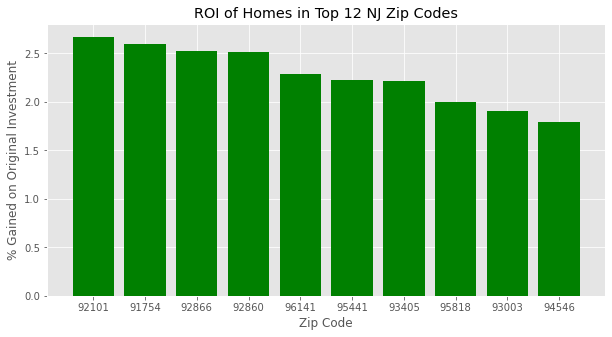

In [41]:
y = [2.67, 2.60, 2.53, 2.51, 2.29, 2.23, 2.22, 2, 1.91, 1.79]

plt.figure(figsize=(10,5))
plt.bar(ziplist, y, color='green')
plt.title('ROI of Homes in Top 12 NJ Zip Codes')
plt.xlabel('Zip Code')
plt.ylabel('% Gained on Original Investment')
plt.savefig('images/top12homesroi.png', dpi=300)
plt.show()

In [42]:
#create a dictionary for each zipcode
ts = {}
for zc in ziplist:
    temp_df = melted_df.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [43]:
ts

{'92101': Date
 1996-04-01    147000.0
 1996-05-01    147400.0
 1996-06-01    147700.0
 1996-07-01    148100.0
 1996-08-01    148500.0
                 ...   
 2017-12-01    624900.0
 2018-01-01    625200.0
 2018-02-01    631800.0
 2018-03-01    644200.0
 2018-04-01    652600.0
 Name: value, Length: 265, dtype: float64,
 '91754': Date
 1996-04-01    188600.0
 1996-05-01    188000.0
 1996-06-01    187400.0
 1996-07-01    186900.0
 1996-08-01    186500.0
                 ...   
 2017-12-01    687700.0
 2018-01-01    691500.0
 2018-02-01    695400.0
 2018-03-01    698500.0
 2018-04-01    700000.0
 Name: value, Length: 265, dtype: float64,
 '92866': Date
 1996-04-01    173700.0
 1996-05-01    173600.0
 1996-06-01    173500.0
 1996-07-01    173500.0
 1996-08-01    173600.0
                 ...   
 2017-12-01    688500.0
 2018-01-01    694600.0
 2018-02-01    700000.0
 2018-03-01    705100.0
 2018-04-01    708000.0
 Name: value, Length: 265, dtype: float64,
 '92860': Date
 1996-04-01    1629

In [44]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,92101,91754,92866,92860,96141,95441,93405,95818,93003,94546
Date,,,,,,,,,,
1996-04-01,147000.0,188600.0,173700.0,162900.0,170600.0,223800.0,181000.0,144000.0,182900.0,202100.0
1996-05-01,147400.0,188000.0,173600.0,162200.0,171800.0,222900.0,181700.0,144300.0,182700.0,201600.0
1996-06-01,147700.0,187400.0,173500.0,161500.0,172900.0,221900.0,182500.0,144500.0,182400.0,201100.0
1996-07-01,148100.0,186900.0,173500.0,160800.0,174000.0,220900.0,183300.0,144500.0,182200.0,200600.0
1996-08-01,148500.0,186500.0,173600.0,160200.0,175100.0,220000.0,184300.0,144600.0,182100.0,200200.0


In [45]:
zip_1 = ziplist[0]

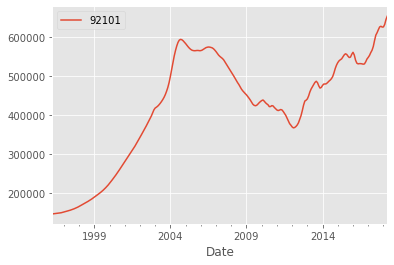

In [46]:
ts_zip1 = ts_df[zip_1].copy()
ax = ts_zip1.plot()
ax.legend()
plt.show()

## Model 1: San Diego (Zipcode 92101)

### Baseline Model

In [47]:
# selected params
d = 1
p = 1
q = 1

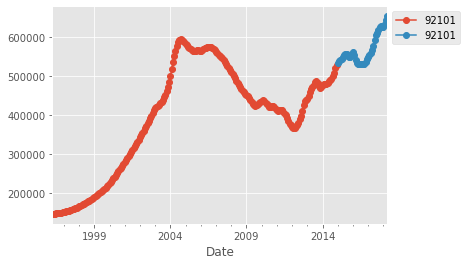

In [48]:
train_size = 0.85 #leaving approximately 3year for test size.
split_idx = round(len(ts_zip1)* train_size)
split_idx

## Split
train = ts_zip1.iloc[:split_idx]
test = ts_zip1.iloc[split_idx:]

## Visualize split
fig,ax= plt.subplots()
kws = dict(ax=ax,marker='o')
train.plot(**kws)
test.plot(**kws)
ax.legend(bbox_to_anchor=[1,1])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  225
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2186.172
Date:                Mon, 02 Aug 2021   AIC                           4378.344
Time:                        16:54:49   BIC                           4388.579
Sample:                    04-01-1996   HQIC                          4382.475
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8545      0.028     30.691      0.000       0.800       0.909
ma.L1         -0.7447      0.034    -22.066      0.000      -0.811      -0.679
sigma2      1.717e+07   1.81e-10   9.51e+16      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (L1) (Q):                 166.96   Jarque-Bera (JB):                78.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.33
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.48e+32. Standard errors may be unstable.
"""

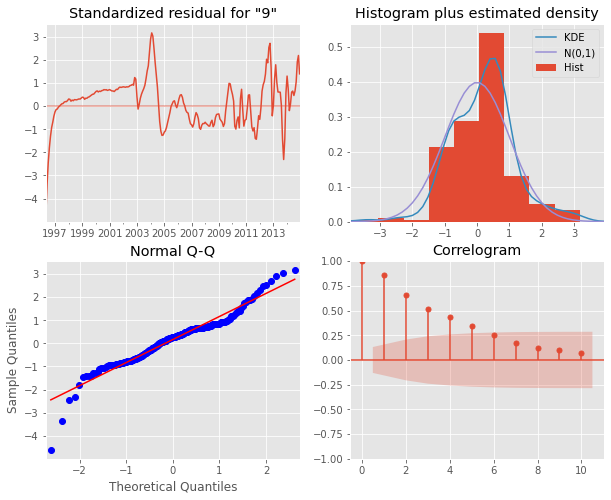

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Baseline model from eye-balled params
model = SARIMAX(train,order=(p,d,q),).fit()
display(model.summary())
model.plot_diagnostics(figsize=(10,8));
plt.show()

In [50]:
## obtaining forecast
from sklearn import metrics
forecast = model.get_forecast(steps=len(test))

In [51]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred

pred_df = forecast_to_df(forecast,zip_1)
pred_df.head()

,lower,upper,prediction
2015-01-01,522605.595442,538850.383548,530727.989495
2015-02-01,521181.403406,545449.226187,533315.314796
2015-03-01,519943.687139,551108.524646,535526.105892
2015-04-01,518665.508443,556164.811388,537415.159916
2015-05-01,517299.090773,560759.507940,539029.299356


In [52]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

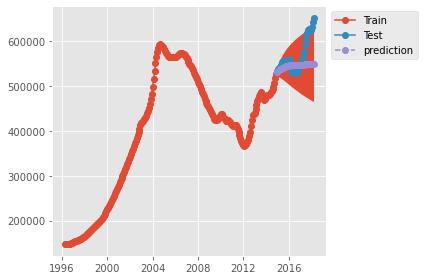

In [53]:
plot_train_test_pred(train,test,pred_df)

plt.show()


## Model 2 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1969.676
Date:                Mon, 02 Aug 2021   AIC                           3943.351
Time:                        16:54:51   BIC                           3950.165
Sample:                             0   HQIC                          3946.102
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0335      0.010      3.394      0.001       0.014       0.053
sigma2      2.722e+06   1.38e+05     19.727      0.000    2.45e+06    2.99e+06
===================================================================================
Ljung-Box (L1) (Q):                  42.82   Jarque-Bera (JB):               252.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              46.81   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

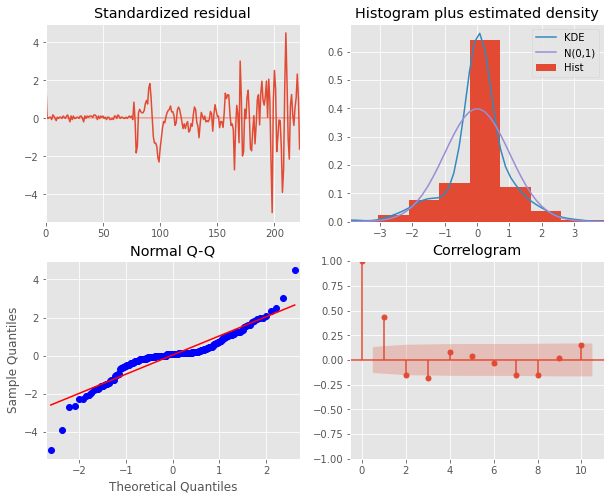

In [54]:
auto_model = auto_arima(train,start_p=0,start_q=0)
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(10,8));

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2402.061
Date:                Mon, 02 Aug 2021   AIC                           4808.121
Time:                        16:54:52   BIC                           4815.266
Sample:                    04-01-1996   HQIC                          4810.993
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0484      0.007      6.748      0.000       0.034       0.062
sigma2      3.546e+06   1.25e+05     28.369      0.000     3.3e+06    3.79e+06
===================================================================================
Ljung-Box (L1) (Q):                  36.26   Jarque-Bera (JB):               280.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.11   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

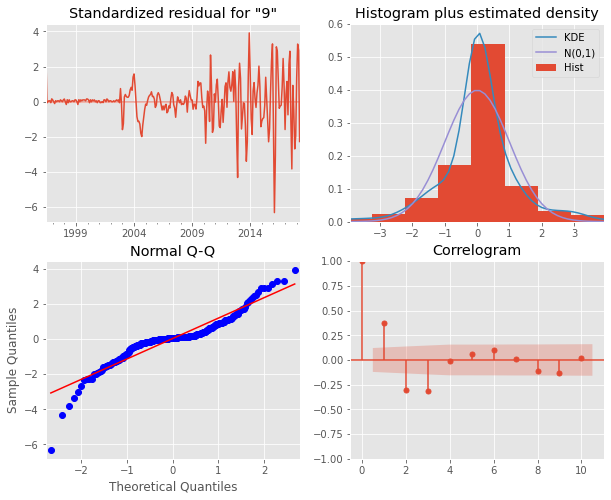

In [55]:
model3 = SARIMAX(ts_zip1,order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order).fit()
display(model3.summary())
model3.plot_diagnostics(figsize=(10,8));

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

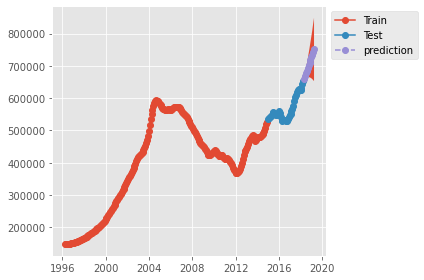

In [56]:
pred = model3.get_forecast(steps=12)#start=test.index[0],end=test.index[-1])
pred_df = forecast_to_df(pred,zip_1)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

92101


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  265
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -2917.063
Date:                Mon, 02 Aug 2021   AIC                           5848.126
Time:                        16:54:58   BIC                           5873.157
Sample:                    04-01-1996   HQIC                          5858.184
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6872      0.028     24.480      0.000       0.632       0.742
ar.L2         -0.0909      0.009    -10.669      0.000      -0.108      -0.074
ar.L3          0.1605      0.004     45.170      0.000       0.154       0.167
ar.L4         -0.1978      0.006    -31.152      0.000      -0.210      -0.185
ar.L5          0.1708      0.003     53.608      0.000       0.165       0.177
ma.L1         -0.4462      0.029    -15.507      0.000      -0.503      -0.390
sigma2      3.761e+06   1.07e-09   3.51e+15      0.000    3.76e+06    3.76e+06
===================================================================================
Ljung-Box (L1) (Q):                  87.43   Jarque-Bera (JB):              1077.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.53
Prob(H) (two-sided):                  0.88   Kurtosis:                        12.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.68e+30. Standard errors may be unstable.
"""

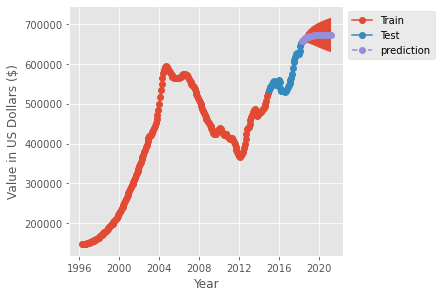

------------------------------------------------------------

91754


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  91754   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2524.423
Date:                Mon, 02 Aug 2021   AIC                           5054.846
Time:                        16:55:01   BIC                           5065.574
Sample:                    04-01-1996   HQIC                          5059.157
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9198      0.020     46.274      0.000       0.881       0.959
ma.L1         -0.8646      0.024    -36.089      0.000      -0.912      -0.818
sigma2      1.148e+07   1.62e-10   7.07e+16      0.000    1.15e+07    1.15e+07
===================================================================================
Ljung-Box (L1) (Q):                 223.81   Jarque-Bera (JB):                41.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.66
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+33. Standard errors may be unstable.
"""

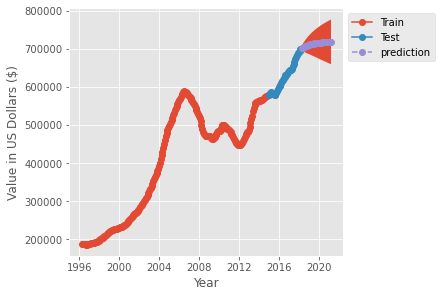

------------------------------------------------------------

92866


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92866   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2539.324
Date:                Mon, 02 Aug 2021   AIC                           5084.647
Time:                        16:55:07   BIC                           5095.375
Sample:                    04-01-1996   HQIC                          5088.958
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9359      0.015     64.344      0.000       0.907       0.964
ma.L1         -0.8737      0.019    -45.852      0.000      -0.911      -0.836
sigma2      1.284e+07   5.21e-11   2.47e+17      0.000    1.28e+07    1.28e+07
===================================================================================
Ljung-Box (L1) (Q):                 215.41   Jarque-Bera (JB):                49.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.67
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+33. Standard errors may be unstable.
"""

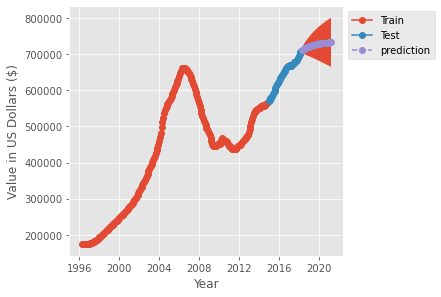

------------------------------------------------------------

92860


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92860   No. Observations:                  265
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2548.852
Date:                Mon, 02 Aug 2021   AIC                           5109.704
Time:                        16:55:11   BIC                           5131.160
Sample:                    04-01-1996   HQIC                          5118.325
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0808      0.005     16.266      0.000       0.071       0.091
ar.L2          0.0767      0.005     13.992      0.000       0.066       0.087
ar.L3          0.0765      0.006     11.871      0.000       0.064       0.089
ar.L4          0.0779      0.007     11.398      0.000       0.065       0.091
ar.L5          0.0800      0.007     11.052      0.000       0.066       0.094
sigma2      1.368e+07    1.6e-11   8.57e+17      0.000    1.37e+07    1.37e+07
===================================================================================
Ljung-Box (L1) (Q):                 214.89   Jarque-Bera (JB):               392.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+33. Standard errors may be unstable.
"""

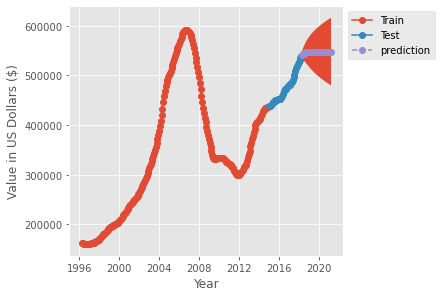

------------------------------------------------------------

96141


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  96141   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2506.975
Date:                Mon, 02 Aug 2021   AIC                           5017.951
Time:                        16:55:12   BIC                           5025.095
Sample:                    04-01-1996   HQIC                          5020.822
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0532      0.009      5.868      0.000       0.035       0.071
sigma2      9.522e+06   6.85e-12   1.39e+18      0.000    9.52e+06    9.52e+06
===================================================================================
Ljung-Box (L1) (Q):                  35.47   Jarque-Bera (JB):                68.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.39   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.5e+33. Standard errors may be unstable.
"""

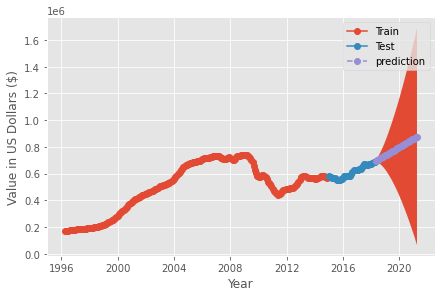

------------------------------------------------------------

95441


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  95441   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2659.699
Date:                Mon, 02 Aug 2021   AIC                           5325.398
Time:                        16:55:16   BIC                           5336.126
Sample:                    04-01-1996   HQIC                          5329.709
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.002    661.939      0.000       0.997       1.003
ma.L1         -0.9985      0.010    -99.314      0.000      -1.018      -0.979
sigma2       3.29e+07   8.93e-12   3.69e+18      0.000    3.29e+07    3.29e+07
===================================================================================
Ljung-Box (L1) (Q):                 187.83   Jarque-Bera (JB):                 6.90
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               8.73   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+34. Standard errors may be unstable.
"""

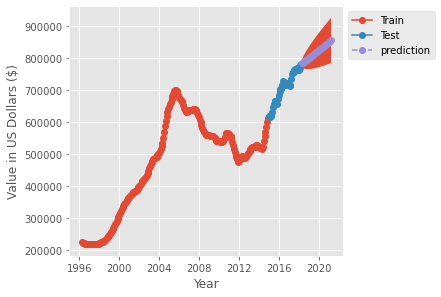

------------------------------------------------------------

93405


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  93405   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2546.633
Date:                Mon, 02 Aug 2021   AIC                           5099.266
Time:                        16:55:19   BIC                           5109.994
Sample:                    04-01-1996   HQIC                          5103.577
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9449      0.016     60.052      0.000       0.914       0.976
ma.L1         -0.8914      0.021    -42.989      0.000      -0.932      -0.851
sigma2      1.367e+07   1.15e-10   1.19e+17      0.000    1.37e+07    1.37e+07
===================================================================================
Ljung-Box (L1) (Q):                 201.96   Jarque-Bera (JB):                 5.53
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.30   Skew:                            -0.24
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+33. Standard errors may be unstable.
"""

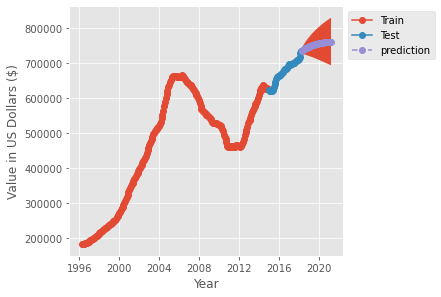

------------------------------------------------------------

95818


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  95818   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2482.895
Date:                Mon, 02 Aug 2021   AIC                           4971.790
Time:                        16:55:25   BIC                           4982.518
Sample:                    04-01-1996   HQIC                          4976.101
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9099      0.019     49.149      0.000       0.874       0.946
ma.L1         -0.8372      0.023    -36.314      0.000      -0.882      -0.792
sigma2      8.247e+06   1.49e-10   5.54e+16      0.000    8.25e+06    8.25e+06
===================================================================================
Ljung-Box (L1) (Q):                 213.12   Jarque-Bera (JB):                56.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.73
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.62e+35. Standard errors may be unstable.
"""

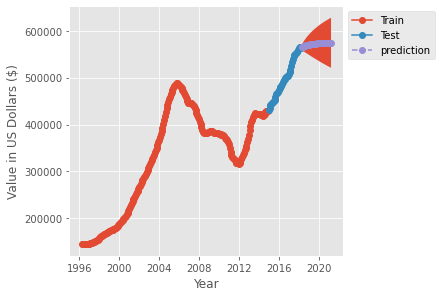

------------------------------------------------------------

93003


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  93003   No. Observations:                  265
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2561.919
Date:                Mon, 02 Aug 2021   AIC                           5135.839
Time:                        16:55:29   BIC                           5157.294
Sample:                    04-01-1996   HQIC                          5144.460
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0791      0.005     16.371      0.000       0.070       0.089
ar.L2          0.0710      0.006     12.867      0.000       0.060       0.082
ar.L3          0.0673      0.007     10.133      0.000       0.054       0.080
ar.L4          0.0663      0.007      9.190      0.000       0.052       0.080
ar.L5          0.0669      0.008      8.691      0.000       0.052       0.082
sigma2      1.524e+07   1.31e-11   1.16e+18      0.000    1.52e+07    1.52e+07
===================================================================================
Ljung-Box (L1) (Q):                 214.83   Jarque-Bera (JB):               248.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.44e+33. Standard errors may be unstable.
"""

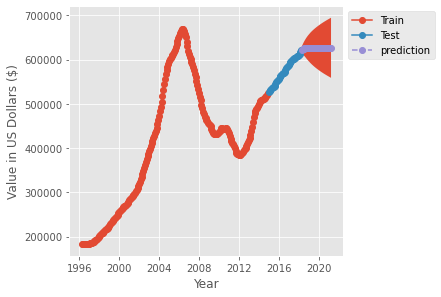

------------------------------------------------------------

94546


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  94546   No. Observations:                  265
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2609.788
Date:                Mon, 02 Aug 2021   AIC                           5227.577
Time:                        16:55:34   BIC                           5241.881
Sample:                    04-01-1996   HQIC                          5233.325
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.002    540.415      0.000       0.995       1.003
ma.L1         -0.8754      0.006   -148.749      0.000      -0.887      -0.864
ma.L2         -0.1195      0.008    -14.821      0.000      -0.135      -0.104
sigma2      2.198e+07   2.25e-11   9.77e+17      0.000     2.2e+07     2.2e+07
===================================================================================
Ljung-Box (L1) (Q):                 193.99   Jarque-Bera (JB):               135.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+33. Standard errors may be unstable.
"""

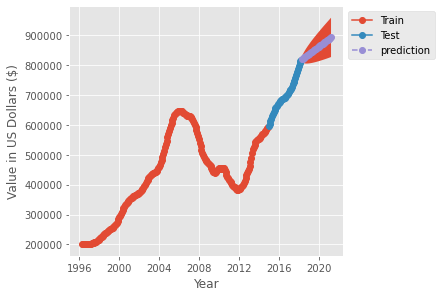

------------------------------------------------------------



In [57]:
RESULTS = {}

for zc in ziplist:
    print(zc)
    
    ## Make empty dict for district data
    zipcode_d = {}
    
    ## Copy Time Series
    ts_final = ts_df[zc].copy()
    
    ## Train Test Split Index
    train_size = 0.85
    split_idx = round(len(ts_df)* train_size)

    ## Split
    train = ts_final.iloc[:split_idx]
    test = ts_final.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(ts_final,start_p=0,start_q=0)
    model3 = SARIMAX(ts_final,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = model3.get_forecast(steps=36)#start=test.index[0],end=test.index[-1])
    pred_df = forecast_to_df(pred,zc)

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = model3
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(model3.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.show()
    
    
    ## Save district dict in RESULTS
    RESULTS[zc] = zipcode_d
    print('---'*20,end='\n\n')

From the predictions, we can see that the best zip codes are 96141, 95441, 92866, 93405, and 94546 since those are with the lowest number of parameters from the summary. Let's check for stationarity and measure their future returns.

In [58]:
zip_96141 = melted_df[melted_df.ZipCode == '96141']
zip_93405 = melted_df[melted_df.ZipCode == '93405']
zip_92866 = melted_df[melted_df.ZipCode == '92866']
zip_95441 = melted_df[melted_df.ZipCode == '95441']
zip_94546 = melted_df[melted_df.ZipCode == '94546']

In [59]:
zip_df = pd.DataFrame()
zip_df = zip_df.append(zip_96141)
zip_df = zip_df.append(zip_93405)
zip_df = zip_df.append(zip_92866)
zip_df = zip_df.append(zip_95441)
zip_df = zip_df.append(zip_94546)
zip_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,96141,Homewood,CA,Sacramento,Placer,170600.0
1996-05-01,96141,Homewood,CA,Sacramento,Placer,171800.0
1996-06-01,96141,Homewood,CA,Sacramento,Placer,172900.0
1996-07-01,96141,Homewood,CA,Sacramento,Placer,174000.0
1996-08-01,96141,Homewood,CA,Sacramento,Placer,175100.0


In [60]:
zip_ts = []
for zc in zip_df.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    top5_df = zip_df[zip_df['ZipCode']==zc].asfreq('MS')
    zip_ts.append(top5_df)
zip_ts[0].head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,96141,Homewood,CA,Sacramento,Placer,170600.0
1996-05-01,96141,Homewood,CA,Sacramento,Placer,171800.0
1996-06-01,96141,Homewood,CA,Sacramento,Placer,172900.0
1996-07-01,96141,Homewood,CA,Sacramento,Placer,174000.0
1996-08-01,96141,Homewood,CA,Sacramento,Placer,175100.0


In [61]:
for i in range(len(zip_ts)):
    print(f'Value descriptive statistics for zipcode {zip_ts[i].ZipCode[0]}:')
    print(f'{zip_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 96141:
count       265.000000
mean     515559.245283
std      174156.566619
min      170600.000000
25%      436900.000000
50%      564100.000000
75%      665600.000000
max      742600.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 93405:
count       265.000000
mean     492692.452830
std      161513.696118
min      181000.000000
25%      381300.000000
50%      526800.000000
75%      629700.000000
max      733400.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 92866:
count       265.000000
mean     453692.830189
std      159994.514541
min      173500.000000
25%      307000.000000
50%      465300.000000
75%      582900.000000
max      708000.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 95441:
count       265.000000
mean     505475.094340
std      159638.512285
min      217200.000000
25%      388700.000000
50%      527400.000000
75%      633400.000000
max     

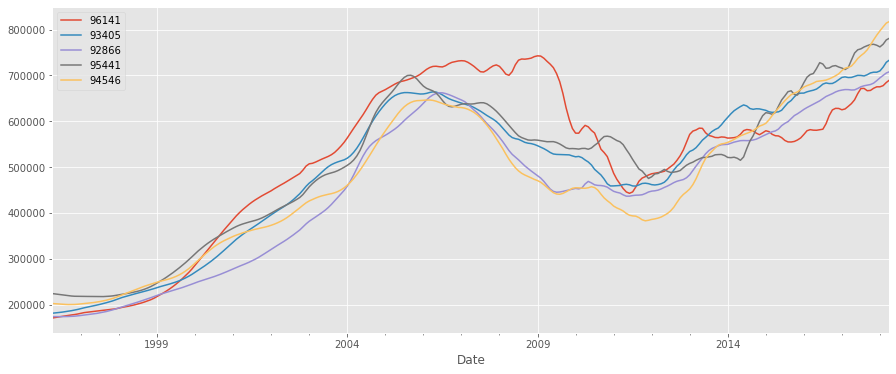

In [62]:
for i in range(5):
    zip_ts[i].value.plot(label=zip_ts[i].ZipCode[0],figsize=(15,6))
    plt.legend()

In [63]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(zip_ts)):
    zip_ts[zc]['ret']=np.nan*len(zip_ts[zc])
    for i in range(len(zip_ts[zc])-1):
        zip_ts[zc]['ret'][i+1]= (zip_ts[zc].value.iloc[i+1] / zip_ts[zc].value.iloc[i]) - 1

In [64]:
for i in range(5):
    results = adfuller(zip_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 96141
p-value: 0.243487362447878
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 93405
p-value: 0.16677983660591333
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 92866
p-value: 0.3421318160724609
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 95441
p-value: 0.16014965341653276
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 94546
p-value: 0.1548027613969144
Fail to reject the null hypothesis. Data is not stationary.



Except for the last zipcode we fail to reject the null hypothesis that the data is not stationary.

In [65]:
roll_mean = top5_df['value'].rolling(window=8, center=False).mean()
roll_std = top5_df['value'].rolling(window=8, center=False).std()
# series_ts = pd.Series()

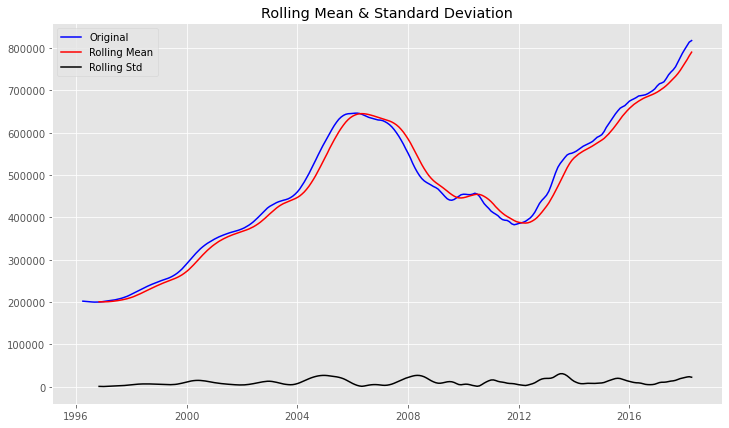

In [66]:
fig = plt.figure(figsize=(12,7))
plt.plot(top5_df['value'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [67]:
for i in [0,1,2,3,4]:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(zip_ts[i].ret.diff(12).dropna()) #differencing by 12 month for stationarity
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 96141
p-value: 0.036874669018307694
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 93405
p-value: 0.02484354616576152
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 92866
p-value: 0.01977222550785072
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 95441
p-value: 0.0020025794810129625
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 94546
p-value: 0.006682863547727758
Reject the null hypothesis. Data is stationary.



In [68]:
results

(-3.5549584208197214,
 0.006682863547727758,
 15,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 -2136.0421152611502)

In [69]:
zip_ts

[           ZipCode      City State       Metro CountyName     value       ret
 Date                                                                         
 1996-04-01   96141  Homewood    CA  Sacramento     Placer  170600.0       NaN
 1996-05-01   96141  Homewood    CA  Sacramento     Placer  171800.0  0.007034
 1996-06-01   96141  Homewood    CA  Sacramento     Placer  172900.0  0.006403
 1996-07-01   96141  Homewood    CA  Sacramento     Placer  174000.0  0.006362
 1996-08-01   96141  Homewood    CA  Sacramento     Placer  175100.0  0.006322
 ...            ...       ...   ...         ...        ...       ...       ...
 2017-12-01   96141  Homewood    CA  Sacramento     Placer  675000.0  0.004763
 2018-01-01   96141  Homewood    CA  Sacramento     Placer  675000.0  0.000000
 2018-02-01   96141  Homewood    CA  Sacramento     Placer  677500.0  0.003704
 2018-03-01   96141  Homewood    CA  Sacramento     Placer  684400.0  0.010185
 2018-04-01   96141  Homewood    CA  Sacramento     

In [70]:
#Create individual time series for each of the positive zipcodes
TS_96141 = zip_ts[0].ret.dropna()
TS_96141d = zip_ts[0].ret.diff().dropna()

TS_93405 = zip_ts[1].ret.dropna()
TS_93405d = zip_ts[1].ret.diff().dropna()

TS_92866 = zip_ts[2].ret.dropna()
TS_92866d = zip_ts[2].ret.diff().dropna()

TS_95441 = zip_ts[3].ret.dropna()
TS_95441d = zip_ts[3].ret.diff().dropna()

TS_94546 = zip_ts[4].ret.dropna()
TS_94546d = zip_ts[4].ret.diff().dropna()

In [71]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    ts.plot(ax=ax[0])
    
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

def seasonal_plots(df,N=4,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = df - df.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

def model_fit(df,pdq=(1,0,1),pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

def forecast_model(df,pdq=(1,0,1),pdqs=(0,0,0,12), display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

# Zipcode 96141: Placer county

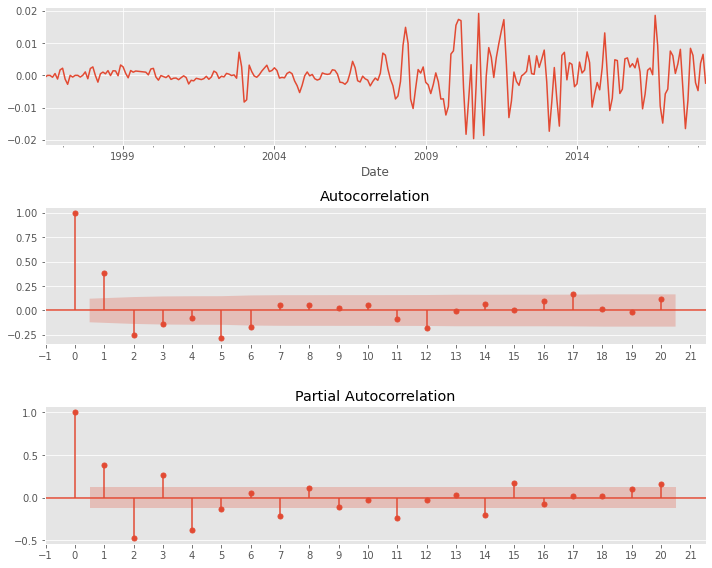

In [72]:
plot_acf_pacf(TS_96141d,lags=20);

Even though the data lines after differencing do seem to be fluctuating, the movements seem to be completely random, 
and the same conclusion holds for the original time series.

In [73]:
results = pm.auto_arima(TS_96141d,information_criterion='aic',m=12,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1973.757, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1967.345, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2016.851, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2085.945, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1969.345, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2075.458, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2080.524, Time=0.18 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2112.062, Time=0.44 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2102.526, Time=0.99 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-2023.178, Time=0.40 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=-2109.295, Time=1.26 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-2052.711, Time=0.79 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=-2115.132, Time=1.00 sec
 ARIMA(1,0,

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

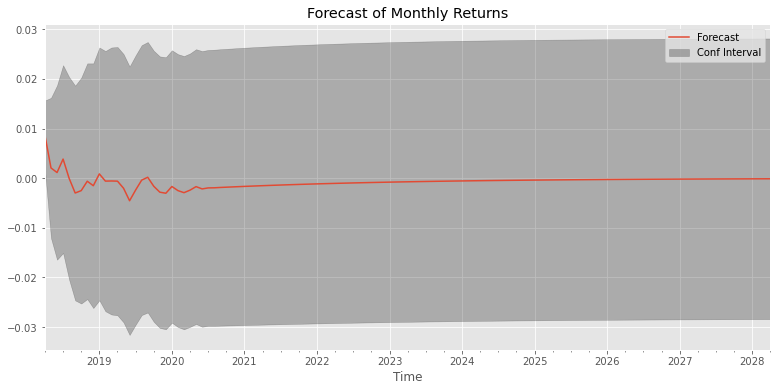

Total expected return in 1 year: 0.77%
Total expected return in 3 years: -3.8%
Total expected return in 5 year: -6.27%
Total expected return in 10 years: -8.15%


In [74]:
pdq = (2, 0, 3)
pdqs = (0, 0, 2, 12)
ret_96141 = forecast_model(TS_96141,pdq=pdq,pdqs=pdqs,zc=96141)

# Zipcode 93405: San Luis Obispo

(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='Date'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

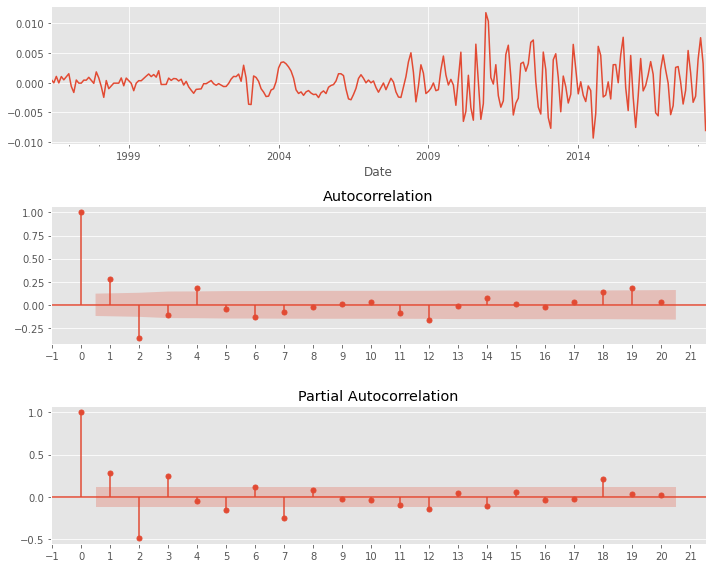

In [75]:
plot_acf_pacf(TS_93405d,lags=20)

The ACF and PACF have just one very strong correlation, right at 1 month.

In [76]:
results = pm.auto_arima(TS_93405d,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2407.891, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2317.198, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2343.228, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2395.193, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2319.194, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2358.138, Time=0.48 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2356.349, Time=0.90 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2407.837, Time=1.51 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2340.974, Time=1.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2352.938, Time=0.24 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2348.885, Time=0.53 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2369.916, Time=1.28 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2381.941, Time=1.60 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2389.867, Time=0.47 sec
 ARIM

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

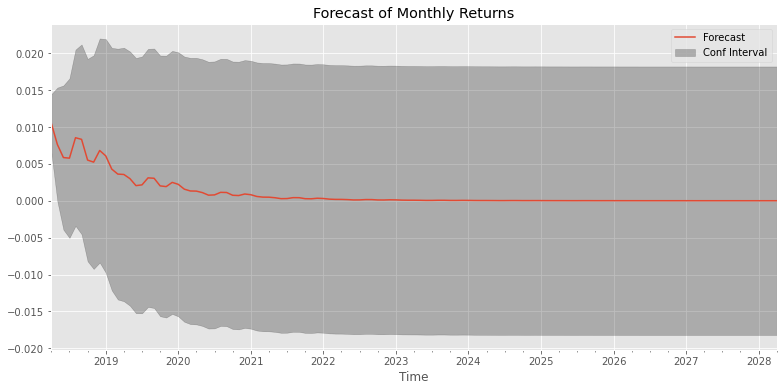

Total expected return in 1 year: 8.1%
Total expected return in 3 years: 12.39%
Total expected return in 5 year: 13.0%
Total expected return in 10 years: 13.13%


In [77]:
pdq = (2, 0, 3)
pdqs = (1, 0, 1, 12)
ret_90504 = forecast_model(TS_93405,pdq=pdq,pdqs=pdqs,zc=90504)

# Zipcode 92866: Orange county

(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='Date'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

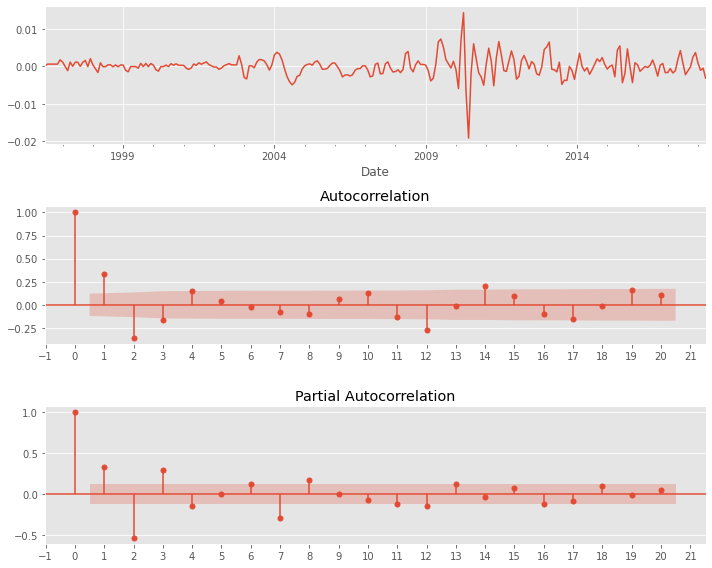

In [78]:
plot_acf_pacf(TS_92866d,lags=20)

The ACF and PACF have just one very strong correlation, right at 2 month.

In [79]:
results = pm.auto_arima(TS_92866d,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2364.192, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2374.893, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2424.396, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2488.801, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2376.881, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2471.526, Time=0.22 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2483.753, Time=0.48 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2488.244, Time=0.48 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2485.630, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2484.540, Time=0.66 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-2396.960, Time=0.35 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2370.483, Time=0.32 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-2317.288, Time=0.70 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-2427.547, Time=0.23 sec
 ARIM

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

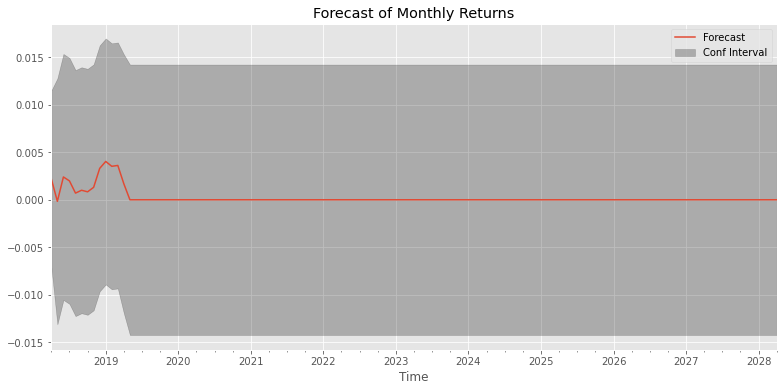

Total expected return in 1 year: 2.5%
Total expected return in 3 years: 2.67%
Total expected return in 5 year: 2.67%
Total expected return in 10 years: 2.67%


In [80]:
pdq = (0, 0, 1)
pdqs = (0, 0, 1, 12)
ret_92866 = forecast_model(TS_92866,pdq=pdq,pdqs=pdqs,zc=92866)

# Zipcode 95441: Sonoma county

(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='Date'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

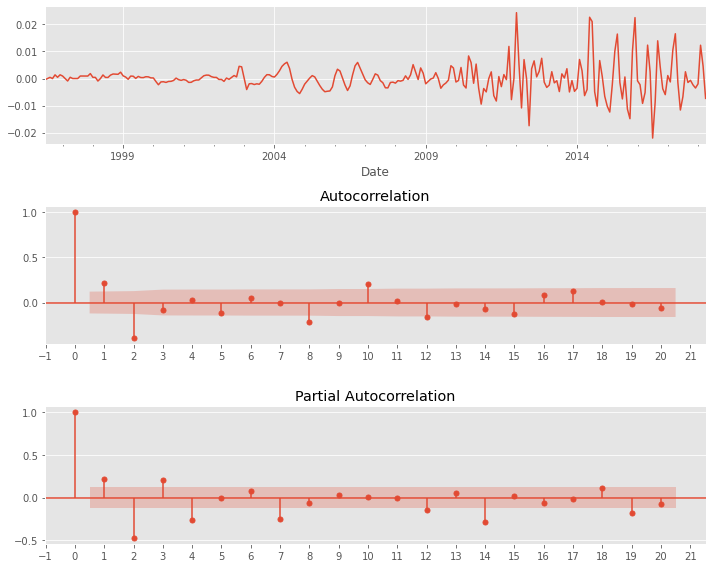

In [81]:
plot_acf_pacf(TS_95441d, lags=20)

The ACF and PACF have just one very strong correlation, right at 2 month.

In [82]:
results = pm.auto_arima(TS_95441,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1645.904, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2023.406, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1598.904, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2020.589, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-2032.534, Time=1.08 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-2035.995, Time=0.83 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-1650.688, Time=0.71 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=-2054.877, Time=1.00 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-2076.245, Time=0.74 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept 

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

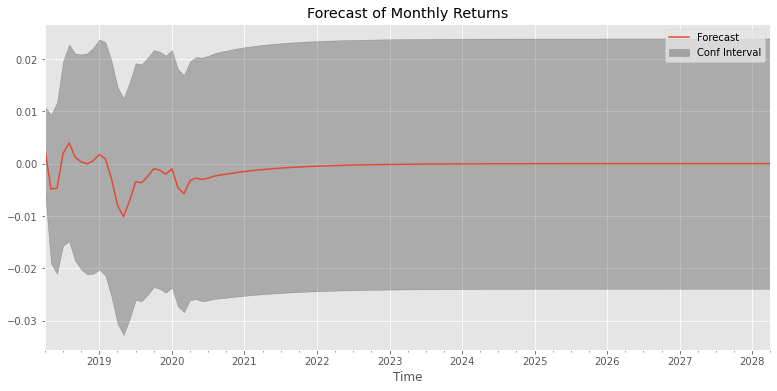

Total expected return in 1 year: 0.1%
Total expected return in 3 years: -7.26%
Total expected return in 5 year: -8.3%
Total expected return in 10 years: -8.42%


In [83]:
pdq = (3, 0, 2)
pdqs = (0, 0, 2, 12)
ret_93405 = forecast_model(TS_95441,pdq=pdq,pdqs=pdqs,zc=93405)

# Zipcode 94546: Alameda county

(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:xlabel='Date'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

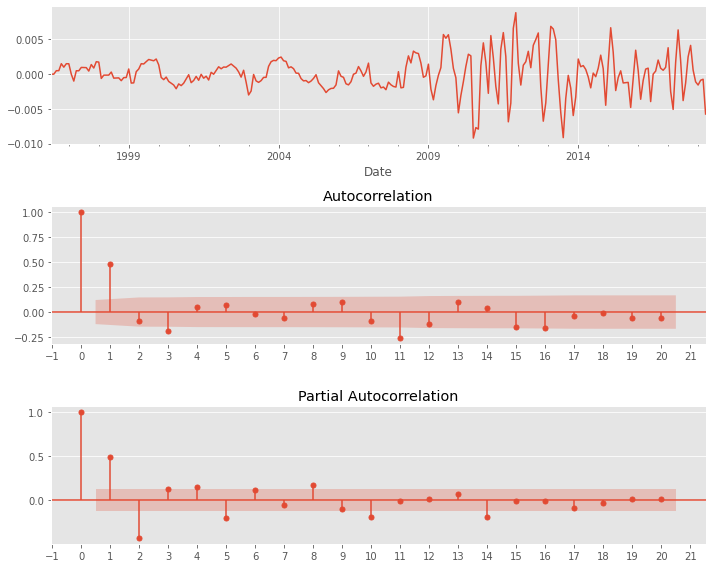

In [84]:
plot_acf_pacf(TS_94546d,lags=20)

The ACF and PACF have just one very strong correlation, right at 1 month.

In [85]:
results = pm.auto_arima(TS_94546,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2476.011, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1667.998, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2295.769, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2013.405, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1605.599, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2486.723, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2487.062, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2486.154, Time=0.43 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-1980.834, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2385.531, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-2496.057, Time=0.30 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-2447.565, Time=0.40 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-2486.533, Time=0.56 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-2457.915, Time=0.61 sec
 ARIM

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

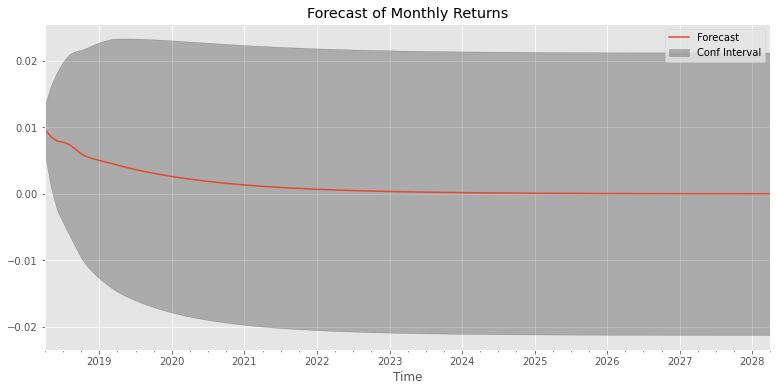

Total expected return in 1 year: 8.22%
Total expected return in 3 years: 14.76%
Total expected return in 5 year: 16.54%
Total expected return in 10 years: 17.16%


In [86]:
# pdq = (3, 0, 2)
# pdqs = (2, 0, 0, 12)
# ret_95818 = forecast_model(TS_95818,pdq=pdq,pdqs=pdqs,zc=95818)

pdq = (2, 0, 2)
pdqs = (0, 0, 1, 12)
ret_94546 = forecast_model(TS_94546,pdq=pdq,pdqs=pdqs,zc=93023)

## RMSE

In [87]:
import math
from sklearn.metrics import mean_squared_error

pred_start = datetime(2018,1,1)
pred_end = datetime(2028,1,1)
test_start = test.index[0]
test_end = test.index[-1]



train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

TypeError: 'module' object is not callable